In [1]:
render = 0

In [2]:
import os
directory = '../../output.demo'
render='svg'
name=os.path.basename(directory)

In [3]:
if not render: render_name = None
else: render_name = render

In [4]:
from charcoal.utils import load_contamination_summary, build_contamination_matrix, filter_contam

import plotly.graph_objects as go

In [5]:
# load contamination summary from given directory!
with open(f'{directory}/contam_summary.json', 'rt') as fp:
    source_d = load_contamination_summary(fp)

In [6]:
source_d

{'GCA_001593925.1_ASM159392v1_genomic.fna.gz': [],
 'LoombaR_2017__SID1050_bax__bin.11.fa.gz': [((LineagePair(rank='superkingdom', name='d__Bacteria'),
    LineagePair(rank='phylum', name='p__Firmicutes_A'),
    LineagePair(rank='class', name='c__Clostridia'),
    LineagePair(rank='order', name='o__Oscillospirales'),
    LineagePair(rank='family', name='f__Acutalibacteraceae'),
    LineagePair(rank='genus', name='g__Anaeromassilibacillus')),
   (LineagePair(rank='superkingdom', name='d__Bacteria'),
    LineagePair(rank='phylum', name='p__Firmicutes_A'),
    LineagePair(rank='class', name='c__Clostridia'),
    LineagePair(rank='order', name='o__Lachnospirales'),
    LineagePair(rank='family', name='f__Anaerotignaceae'),
    LineagePair(rank='genus', name='g__Anaerotignum')),
   7),
  ((LineagePair(rank='superkingdom', name='d__Bacteria'),
    LineagePair(rank='phylum', name='p__Firmicutes_A'),
    LineagePair(rank='class', name='c__Clostridia'),
    LineagePair(rank='order', name='o__Os

In [7]:
# do sorting and filtering
THRESHOLD_F=0.8
sub_list = filter_contam(source_d, THRESHOLD_F, display_at_rank='class')
source_labels, target_labels, mat_l = build_contamination_matrix(sub_list)

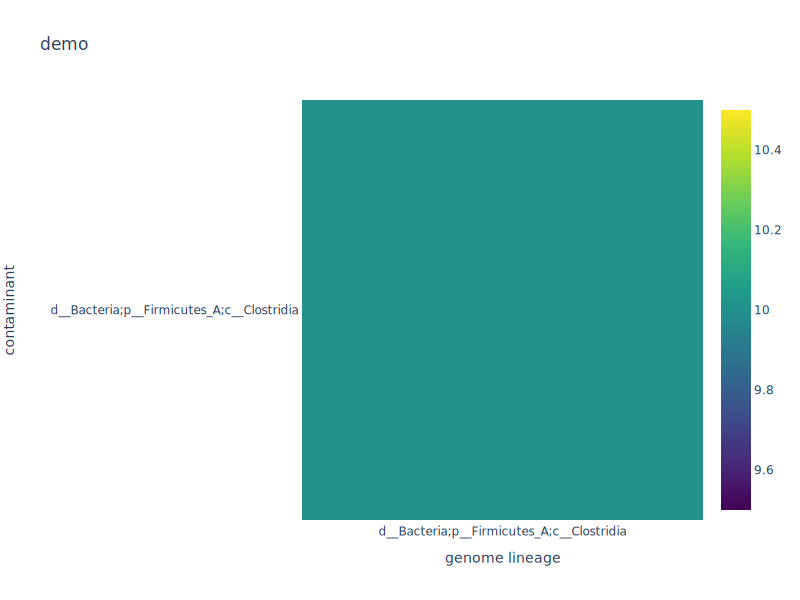

In [8]:
# make actual plot!
fig = go.Figure(data=go.Heatmap(
                   z=mat_l,
                   x=source_labels,
                   y=target_labels,
                   hoverongaps = False,
                   colorscale="Viridis"))
fig.update_layout(xaxis_title='genome lineage', yaxis_title='contaminant',
                  title=f'{name[7:]}')
fig.show(render_name, width=800, height=600)